In [1]:
import pandas as pd

In [2]:
sound=pd.read_csv('assets/dataset_content.csv')

In [4]:
sound.head()

,machine,id,normal,anomalous
0,valve,0,991,119
1,valve,1,869,120
2,valve,2,708,120
3,valve,3,963,120
4,valve,4,1000,120


In [11]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [14]:
y, sr = librosa.load('assets\one.wav')

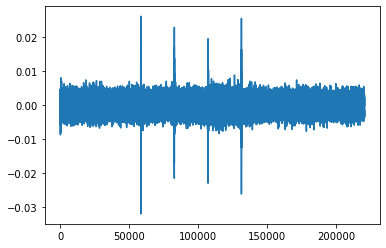

In [15]:
plt.plot(y)